### importing libraries

In [1]:
import librosa as lr
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import PIL
from PIL import Image
from IPython.display import display
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
import sklearn.metrics

The dataset that is used can be found here: [link to dataset](https://urbansounddataset.weebly.com/urbansound8k.html)

First I want to get an overview of the data. Further details on the dataset can also be found in the [write-up](https://github.com/b-ertel/audio-classification-on-a-deaf-machine/audio-classification-on-a-deaf-machine.pdf)

In [2]:
dataframe = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
samples = dataframe.sample(10)
samples

FileNotFoundError: [Errno 2] File UrbanSound8K/metadata/UrbanSound8K.csv does not exist: 'UrbanSound8K/metadata/UrbanSound8K.csv'

# Visualize an example of the audios with an Amplitudeplot, a Spectrogram and a Melspectrogram
### Details on how these plots differ are described in the [write-up](https://github.com/b-ertel/audio-classification-on-a-deaf-machine/audio-classification-on-a-deaf-machine.pdf)

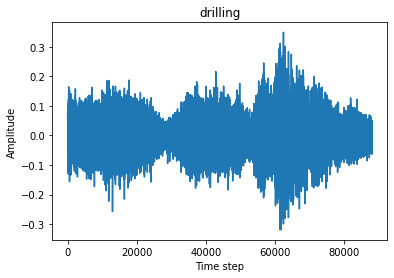

In [77]:
sample1 = samples.iloc[5]
f1 = "UrbanSound8K/audio/fold" + str(sample1['fold']) +"/" + sample1['slice_file_name']
y1, sr1 = librosa.load(f1) #y1 = audio time series; sr1 = sampling rate

#fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(y1)
plt.title(str(sample1['class']))
plt.ylabel("Amplitude")
plt.xlabel("Time step")
plt.show()

### Linear Spectrogram

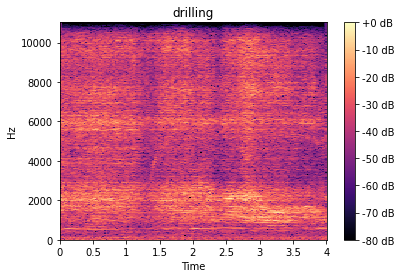

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)

img = librosa.display.specshow(D, y_axis='linear', x_axis='time',

                               sr=sr)

ax.set(title=str(sample1['class']))

fig.colorbar(img, ax=ax, format="%+2.f dB")
#plt.savefig('report/plots/Dog_linear.svg')

### Mel Spectrogram

[Text(0.5, 1.0, 'drilling')]

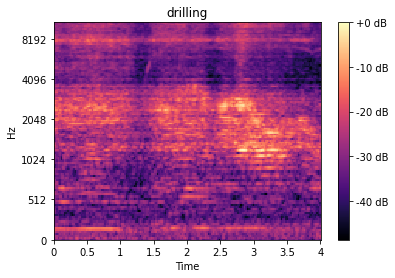

In [79]:
S = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title=str(sample1['class']))

#plt.savefig('report/plots/dog_mel.svg')

# Process data

In [ ]:
for i in range(1,11):
    converted_audios = []
    class_ids = []
    filename_class = []
    new_dataframe = dataframe[dataframe.fold == i]
    for name, class_id in zip(new_dataframe.loc[:,'slice_file_name'], new_dataframe.loc[:,'classID']):
        fname = "UrbanSound8K/audio/fold" + str(i) +"/" + name
        audio, sr = lr.load(fname)
        mel_spectrogram = lr.feature.melspectrogram(audio, sr)
        db_mel_spectrogram = lr.power_to_db(mel_spectrogram, ref=np.max)
        rescaled = (db_mel_spectrogram + 80) / 80 * 255
        while rescaled.shape[1] < 128: 
            rescaled = np.append(rescaled, rescaled, axis = 1)
        image = Image.fromarray(rescaled.astype(np.uint8))
        image_fname =  name[:-4] + ".jpg"
        image.save("audio_images/fold" + str(i) +"/" + image_fname)
        filename_class.append([image_fname, class_id])
    filename_class = pd.DataFrame(filename_class, columns =["filename", "class_id"])
    filename_class.to_csv("audio_images/fold" + str(i) +"/filename_class.csv")